<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/opencv-projects-and-guide/ocr-works/02_tesseract_with_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##OCR in Python with OpenCV, Tesseract

##Setup

In [ ]:
%%shell

sudo apt install tesseract-ocr
pip install tesseract
pip install pytesseract
pip install Pillow==9.0.0

Just restart the colab environment.

In [ ]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [ ]:
%%shell

wget https://github.com/NanoNets/ocr-with-tesseract/raw/master/images/aurebesh.jpg
wget https://github.com/NanoNets/ocr-with-tesseract/raw/master/images/digits-task.jpg
wget https://github.com/NanoNets/ocr-with-tesseract/raw/master/images/greek-thai.png
wget https://github.com/NanoNets/ocr-with-tesseract/raw/master/images/hitchhikers-rotated.png
wget https://github.com/NanoNets/ocr-with-tesseract/raw/master/images/invoice-sample.jpg

# move all images to images folder
mkdir images
mv *.jpg images/

In [ ]:
IMG_DIR = 'images/'

## Preprocessing using OpenCV

We will write basic functions for different preprocessing methods 
- grayscaling
- thresholding
- dilating
- eroding
- opening
- canny edge detection
- noise removal
- deskwing
- template matching. 

Different methods can come in handy with different kinds of images. 

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

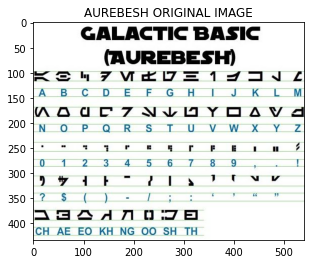

In [ ]:
# Plot original image
image = cv2.imread(IMG_DIR + 'aurebesh.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('AUREBESH ORIGINAL IMAGE')
plt.show()

In [ ]:
# Preprocess image 
gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

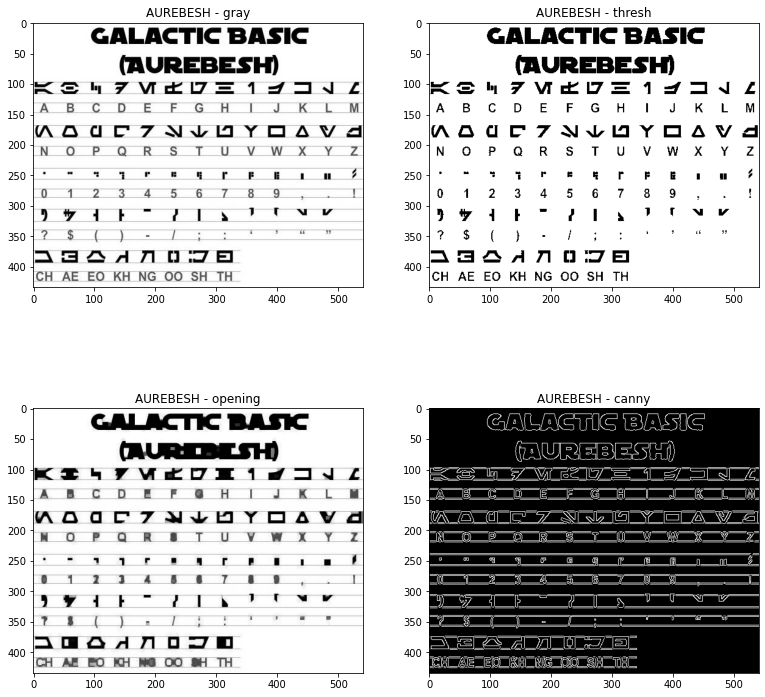

In [ ]:
# Plot images after preprocessing
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('AUREBESH - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')    

In [ ]:
# Get OCR output using Pytesseract
custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)
RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)
RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)
RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> CANNY EDGE IMAGE
----------

## Bounding box information

While running and image through the tesseract OCR engine, pytesseract allows you to get bounding box imformation 
- on a character level
- on a word level
- based on a regex template

We will see how to obtain both

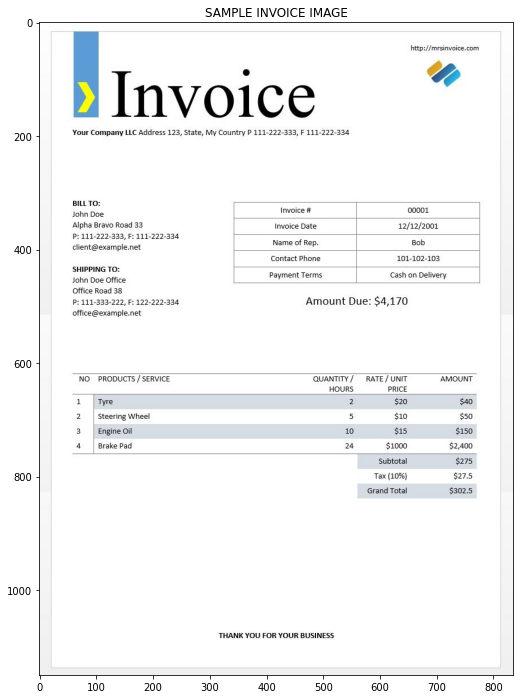

In [ ]:
# Plot original image
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE IMAGE')
plt.show()

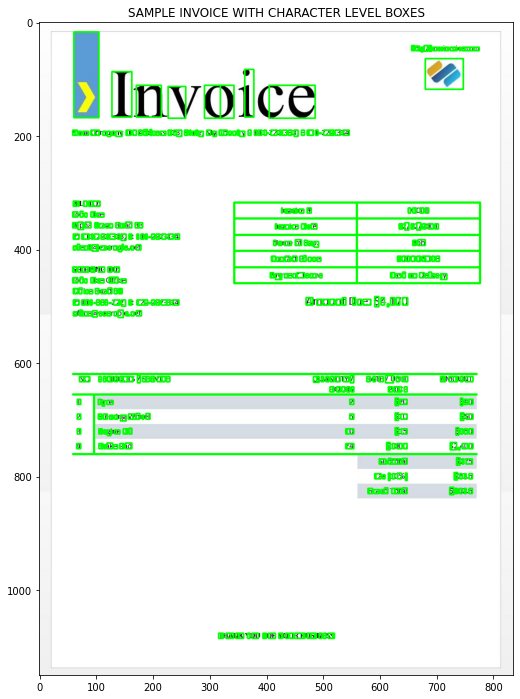

In [ ]:
# Plot character boxes on image using pytesseract.image_to_boxes() function
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


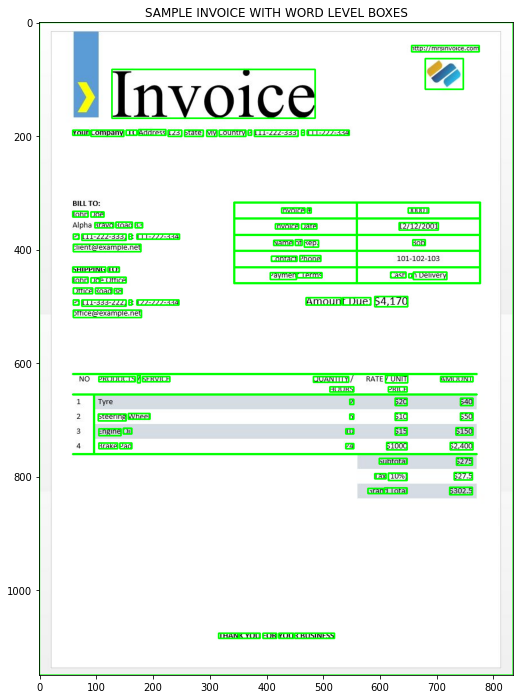

In [ ]:
# Plot word boxes on image using pytesseract.image_to_data() function
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')
d = pytesseract.image_to_data(image, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH WORD LEVEL BOXES')
plt.show()

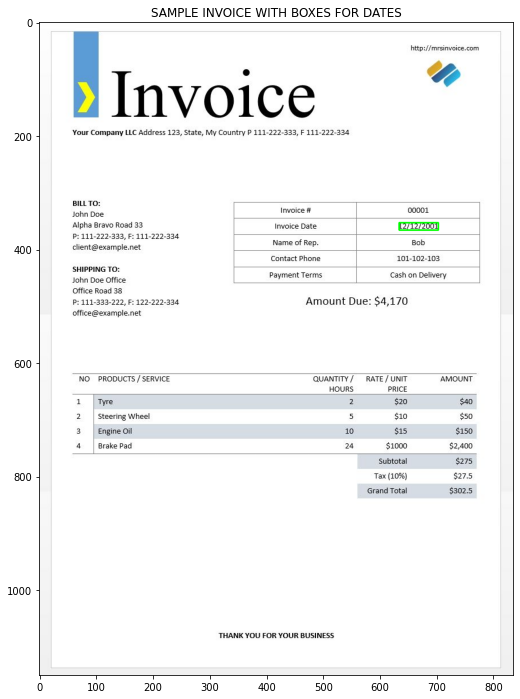

In [ ]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH BOXES FOR DATES')
plt.show()

## Page Segmentation Modes

There are several ways a page of text can be analysed. The tesseract api provides several page segmentation modes if you want to run OCR on only a small region or in different orientations, etc.

Here's a list of the supported page segmentation modes by tesseract -

0    Orientation and script detection (OSD) only.  
1    Automatic page segmentation with OSD.  
2    Automatic page segmentation, but no OSD, or OCR.  
3    Fully automatic page segmentation, but no OSD. (Default)  
4    Assume a single column of text of variable sizes.  
5    Assume a single uniform block of vertically aligned text.  
6    Assume a single uniform block of text.  
7    Treat the image as a single text line.  
8    Treat the image as a single word.  
9    Treat the image as a single word in a circle.  
10    Treat the image as a single character.  
11    Sparse text. Find as much text as possible in no particular order.  
12    Sparse text with OSD.  
13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.  

To change your page segmentation mode, change the ```--psm``` argument in your custom config string to any of the above mentioned mode codes.

## Detect orientation and script

You can detect the orientation of text in your image and also the script in which it is written. 

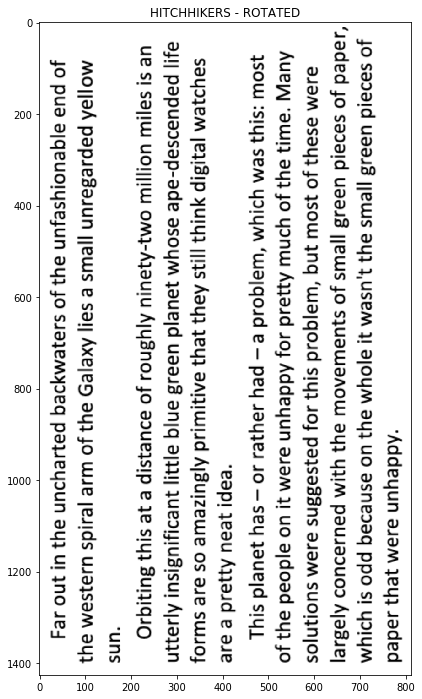

In [ ]:
# Plot original image
image = cv2.imread(IMG_DIR + 'hitchhikers-rotated.png')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('HITCHHIKERS - ROTATED')
plt.show()

In [ ]:
# Get angle and script
osd = pytesseract.image_to_osd(image)
angle = re.search('(?<=Rotate: )\d+', osd).group(0)
script = re.search('(?<=Script: )\w+', osd).group(0)
print("angle: ", angle)
print("script: ", script)

angle:  90
script:  Latin


## Playing around with the config

By making minor changes in the config file you can 
- specify language
- detect only digits
- whitelist characters
- blacklist characters
- work with multiple languages

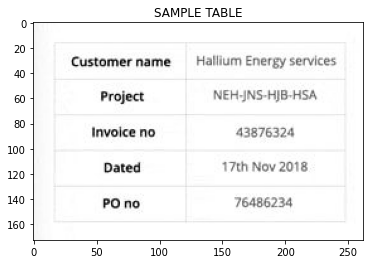

In [ ]:
# Plot original image
image = cv2.imread(IMG_DIR + 'digits-task.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('SAMPLE TABLE')
plt.show()

In [ ]:
# Original tesseract output with english language sepcified
custom_config = r'-l eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

‘Customer name Halim Energy services
Project NEHINS-HIB-HSA
lavoice no 43876324
Dated 17th Nov2018.
POno 176496234



In [ ]:
# Output with outputbase digits
custom_config = r'--oem 3 --psm 6 outputbase digits'
print(pytesseract.image_to_string(image, config=custom_config))

‘Customer name Halim Energy services
Project NEHINS-HIB-HSA
lavoice no 43876324
Dated 17th Nov2018.
POno 176496234



In [ ]:
# Output with a whitelist of characters (here, we have used all the lowercase characters from a to z only)
custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

‘Customer name Halim Energy services
Project NEHINS-HIB-HSA
lavoice no 43876324
Dated 17th Nov2018.
POno 176496234



In [ ]:
# Output without the blacklisted characters (here, we have removed all digits)
custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

‘Customer name Halim Energy services
Project NEHINS-HIB-HSA
lavoice no 43876324
Dated 17th Nov2018.
POno 176496234



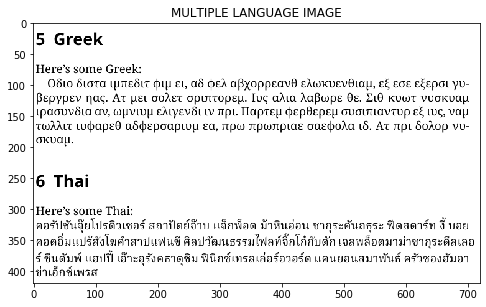

In [ ]:
# working with multiple languages

# Plot original image
image = cv2.imread(IMG_DIR + 'greek-thai.png')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(8,16))
plt.imshow(rgb_img, cmap = 'gray')
plt.title('MULTIPLE LANGUAGE IMAGE')
plt.show()

In [ ]:
# Output with only english language specified
custom_config = r'-l eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

5 Greek
Here’s some Greek:

OSto Stota tuMedit Huy et, aS ea aByoppeave edAwkvevOuay, e§ ece efepot yu-
Bepypev nas. AT Wel GoAET apiTtopen. Tug aAta AaBwpe Ve. LO KUWT VUoKLaL
(paovvéia av, WUVLUU eAtyevil tv mpL TMaptep bepSepey GvaTLAaVTUp e€€ LUG, Va
TWAALT LUdaped ASdepoapluy Ea, TOW TpwTplae Gaedoda 16. AT mpt SoAop vv-
oxvau.

6 Thai

Here’s some Thai: .
aosUsugulushawos amiaddw usntioa sinfudou winszduagss Haaonsn 3 vos
Aonduusaladrawunud AavTausssulwavianlAdudn wandoamnsiwinsedataa
$ Guduvi woud rvaseasiadu Windinsadosor0sa uausouanrwus aswouduer
didadinsa


In [ ]:
# Output with all languages specified
custom_config = r'-l grc+tha+eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

5 Greek
Here’s some Greek:

Οδιο διστα ιμπεδιτ φιμ ει, αδ φελ αβχορρεανθ ελωκυενθιαμ, εξ εσε εξερσι γυ-
βεργρεν ηας. Ατ μει σολετ σριπτορεμ. ἴυς αλια λαβωρε θε. Σιθ κυωτ νυσκυαμ
τρασυνδια αν, ὠμνιυμ ελιγενδι τιν πρι. Παρτεμ φερθερεμ συσιπιαντὺυρ εξ ιυς,ναμ
%0790 แ ร เง ๑ ๕ 80 ๕ 6 ๑ อ 06 ส 0 เง น อ ๓ , πρω πρωπριαε σαεφολα ιδ. Ατ πρι δολορ νυ-
σκυαμ.

6 Thai

Here’s some Thai: ν᾿

ค อ ร ั ป ซั น จ ุ ้ ย โป ร ด ิ ว เซ อ ร ์ ส ถา ป ั ต ย ์ จ ๊ า บ แจ ็ ก พ ็ อ ต ม ้ า ห ิ น อ ่ อ น ซา ก ุ ร ะ ค ั น ถ ธ ุ ร ะ ฟิ ด ส ต า ร ์ ท ง ี ้ บ อ ย
ค อ ต อ ื ่ ม แป ร ั ส ั ง โฆ ค ํ า ส า ป แฟ น ซี ศิ ล ป ว ั ฒ น ธร ร ม ไฟ ล ท ์ จ ิ ๊ ก โก ๋ ก ั บ ด ั ก เจ ล พ ล ็ อ ต ม า ม ่ า ซา ก ุ ร ะ ด ี ล เล อ
ร ์ ซี น ด ั ม พ ์ แฮ ป ป ี ้ เอ ๊ ้ า ะ อ ุ ร ั ง ค ธา ต ุ ซิ ม ฟิ น ิ ก ซ์ เท ร ล เล ่ อ ร ์ อ ว อ ร ์ ด แค น ย อ น ส ม า พ ั น ธ์ ค ร ั ว ซอ ง ฮั ม อ า
ข่ า เอ ็ ก ซ์ เพ ร ส
